In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

In [53]:
# Functions Dump
def K_means(image, k=3, max_iter=100):
    # Reshape the image to a 2D array of pixels
    pixel_values = image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)

    # Define criteria and apply kmeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to uint8
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

def contrast_stretching(image):
    image = np.float32(image)
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = (image - min_val) * (255 / (max_val - min_val))
    stretched_image = np.clip(stretched_image, 0, 255).astype(np.uint8)
    return stretched_image


In [86]:
# generating Histogram plots
def calculate_histogram(directory_path, folder_name, image_name):
    image_path = f"{directory_path}/{folder_name}/{image_name}"
    img_bgr = cv2.imread(image_path)

    path = f"{directory_path}/{folder_name}/"
    x = glob.glob(f'{directory_path}/{folder_name}/*.jpg')



    h_hist = np.zeros((180, 1), dtype=np.float32)
    s_hist = np.zeros((256, 1), dtype=np.float32)
    v_hist = np.zeros((256, 1), dtype=np.float32)


    for path in x:
        img_bgr = cv2.imread(path)
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        h_hist += cv2.calcHist([h], [0], None, [180], [0, 180])
        s_hist += cv2.calcHist([s], [0], None, [256], [0, 256])
        v_hist += cv2.calcHist([v], [0], None, [256], [0, 256])

    if len(x) > 0:
        h_hist /= len(x)
        s_hist /= len(x)
        v_hist /= len(x)

    # Plot results
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Sample Image")

    plt.subplot(2, 2, 2)
    plt.plot(h_hist, color='magenta')
    plt.title("Average Hue Histogram")

    plt.subplot(2, 2, 3)
    plt.plot(s_hist, color='green')
    plt.title("Average Saturation Histogram")

    plt.subplot(2, 2, 4)
    plt.plot(v_hist, color='gray')
    plt.title("Average Value Histogram")

    plt.tight_layout()
    plt.show()




In [75]:
# Segmentation using k-means clustering
img = cv2.imread(r'./wbc_data/Train/Basophil/Basophil_2.jpg', cv2.COLOR_BGR2HSV)
img = contrast_stretching(img)
img2 = K_means(img, 2, 50)
cv2.imshow('Original', img)
cv2.imshow('Segmented', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()




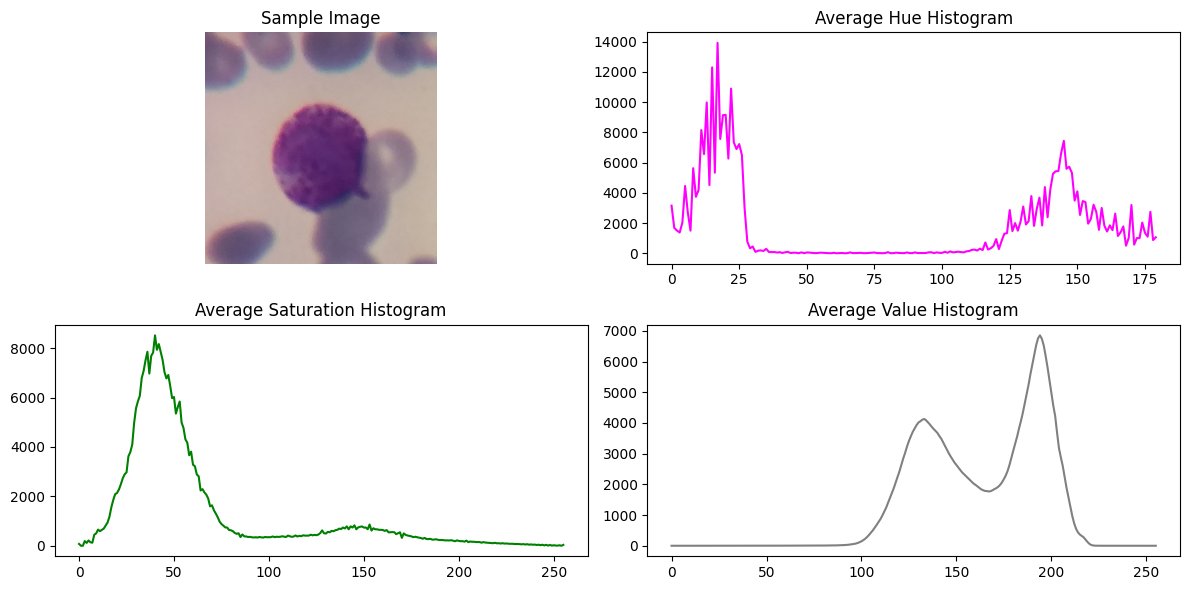

In [87]:
calculate_histogram('./wbc_data/Train/', 'Basophil/', 'Basophil_7.jpg')
